In [1]:
import pyedflib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from scipy.stats import entropy
from scipy.signal import butter, lfilter, filtfilt
from scipy.signal import welch

from sympy import symbols, integrate, exp, sqrt, pi
from scipy.stats import norm

from collections import Counter            

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Conv1D, MaxPooling1D, LSTM, TimeDistributed, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import mne 

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
# read data 

path = "sleep_data\\recordings\\"
Data = pd.DataFrame()

for i in range(1 , 6):
    name_signal = path + 'SN00' + str(i) +'.edf'
    name_sleepscoring = path + 'SN00' + str(i) +'_sleepscoring.txt'
    
    #open edf file
    raw = mne.io.read_raw_edf(name_signal, preload=True , verbose=False)        
    
    # get EEG channels
    eeg_channels = [ch for ch in raw.ch_names if 'EEG' in ch]

    raw_eeg = raw.pick_channels(eeg_channels)
    
    # filter data from 0.1 to 100 hz
    raw_eeg.filter(0.1, 100 , verbose=False)  
    
    # downsample from 256 to 100 hz
    eeg_resample = raw_eeg.copy().resample(100) 
    eeg_data = eeg_resample.get_data()   
    #eeg_data = raw_eeg.get_data()
    
    # read sleep score txt
    sleepscoring = pd.read_csv(name_sleepscoring)
    
    # delet space in text
    sleepscoring.columns = sleepscoring.columns.str.strip()
    sleepscoring['Stage'] = sleepscoring['Annotation'].str.replace('Sleep stage', '', regex=False)
    sleepscoring = sleepscoring.applymap(lambda x: x.strip() if isinstance(x, str) else x) 
    sleepscoring = sleepscoring[~sleepscoring['Stage'].str.contains('Lights')] 
     
    Stage =  sleepscoring['Stage']
    
    #print(Stage)
    
    n = len(Stage)    
    
    cur_signal = pd.DataFrame()
    
    # reshape signal data 
    for k in range(len(eeg_channels)):
        signal = eeg_data[k][:(n*100*30)]
        signal_name = eeg_channels[k].replace(" ", "-")
        
        tmp_signal = signal.reshape(n, (100*30))
        tmp_signal = pd.DataFrame(tmp_signal)
        
        tmp_signal.columns = [signal_name + '-' + str(i) for i in range(100*30)]
        
        cur_signal = pd.concat([cur_signal, tmp_signal], axis=1)     
    
    cur_signal['stage'] = Stage.values
    cur_signal['ID'] = i
                                        
    Data = pd.concat([Data, cur_signal], ignore_index=True)                                

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [5]:
Data.isna().sum().sum()

0

In [8]:
Data.describe()

,EEG-F4-M1-0,EEG-F4-M1-1,EEG-F4-M1-2,EEG-F4-M1-3,EEG-F4-M1-4,EEG-F4-M1-5,EEG-F4-M1-6,EEG-F4-M1-7,EEG-F4-M1-8,EEG-F4-M1-9,...,EEG-C3-M2-2991,EEG-C3-M2-2992,EEG-C3-M2-2993,EEG-C3-M2-2994,EEG-C3-M2-2995,EEG-C3-M2-2996,EEG-C3-M2-2997,EEG-C3-M2-2998,EEG-C3-M2-2999,ID
count,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,...,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,4.639000e+03,4639.000000
mean,3.708058e-07,7.319300e-07,6.286211e-07,7.400277e-07,7.291904e-07,8.946320e-07,5.469250e-07,6.387834e-07,7.409406e-07,7.155429e-07,...,-9.652425e-09,-3.822965e-07,2.339619e-07,-4.508780e-07,-1.344817e-07,1.456805e-07,2.964280e-07,-6.501613e-08,-3.085178e-07,3.079759
std,3.266456e-05,3.171358e-05,3.240803e-05,3.227025e-05,3.215144e-05,3.172305e-05,3.154821e-05,3.184420e-05,3.128485e-05,3.165376e-05,...,3.465070e-05,3.481147e-05,3.450499e-05,3.540206e-05,3.565310e-05,3.595970e-05,3.589296e-05,3.549529e-05,3.517606e-05,1.400309
min,-6.799727e-04,-6.839105e-04,-6.763496e-04,-6.795901e-04,-6.769682e-04,-6.795802e-04,-6.756508e-04,-6.799340e-04,-6.728999e-04,-6.759156e-04,...,-8.029361e-04,-8.193224e-04,-7.971512e-04,-7.858869e-04,-7.697750e-04,-7.501963e-04,-7.292233e-04,-7.356127e-04,-7.321790e-04,1.000000
25%,-8.887193e-06,-8.570243e-06,-8.653151e-06,-8.422149e-06,-8.660393e-06,-8.672909e-06,-9.040380e-06,-8.573206e-06,-9.313151e-06,-9.252388e-06,...,-7.847636e-06,-8.460957e-06,-7.910821e-06,-8.305909e-06,-8.143074e-06,-7.594307e-06,-7.729822e-06,-7.968600e-06,-8.501506e-06,2.000000
50%,1.491886e-07,5.019492e-07,6.208169e-07,5.580455e-07,4.197243e-07,4.750039e-07,2.109036e-07,3.874529e-07,4.266429e-07,6.156375e-07,...,-2.214364e-07,-5.904256e-07,3.772635e-07,-2.177888e-07,1.075115e-07,2.250991e-07,1.250527e-07,-1.799906e-07,-1.056069e-07,3.000000
75%,9.470737e-06,9.498864e-06,9.565315e-06,9.602477e-06,9.764570e-06,1.011073e-05,9.765042e-06,9.622805e-06,9.780911e-06,9.737442e-06,...,7.997645e-06,7.727595e-06,8.538014e-06,7.734745e-06,7.957487e-06,8.350959e-06,8.507768e-06,8.192921e-06,7.969230e-06,4.000000
max,4.765144e-04,4.749016e-04,4.809542e-04,4.465723e-04,4.879492e-04,4.808288e-04,4.464910e-04,4.472616e-04,4.451443e-04,4.237128e-04,...,7.801085e-04,7.895586e-04,7.802501e-04,7.895809e-04,7.803919e-04,7.896046e-04,7.805342e-04,7.896292e-04,7.806769e-04,5.000000


In [9]:
Data.to_csv('preprocess_data.csv', index=False)

In [156]:
raw = mne.io.read_raw_edf("sleep_data\\recordings\\SN001.edf", preload=True , verbose=False)

# get EEG channels
eeg_channels = [ch for ch in raw.ch_names if 'EEG' in ch]

raw_eeg = raw.pick_channels(eeg_channels)

# filter data 
eeg = raw_eeg.get_data()[0]
raw_eeg.filter(0.1, 100 , verbose=False) 
eeg_filtered = raw_eeg.get_data()[0]

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [142]:
t = np.linspace(0, int(len(eeg)/256), int(256 * int(len(eeg)/256)), endpoint=False) 

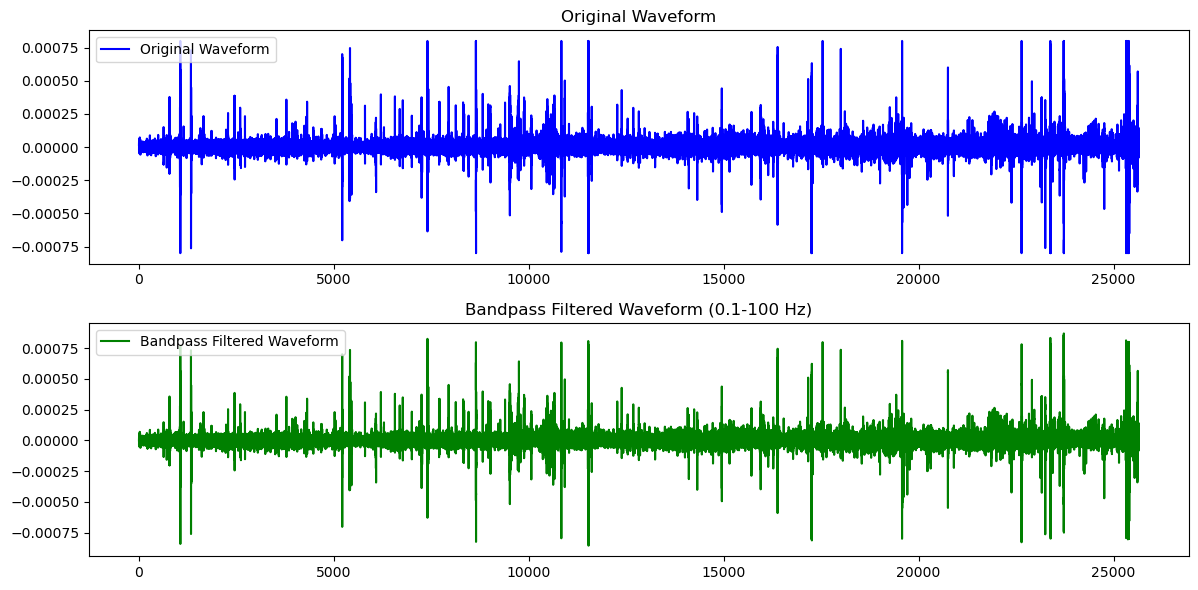

In [151]:
#  plot raw signal and filtered signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, eeg, 'b-', label='Original Waveform')
plt.legend(loc='best')
plt.title('Original Waveform')
plt.subplot(2, 1, 2)
plt.plot(t, eeg_filtered, 'g-', label='Bandpass Filtered Waveform')
plt.legend(loc='best')
plt.title('Bandpass Filtered Waveform ({}-{} Hz)'.format(0.1, 100))
plt.tight_layout()
plt.show()

In [167]:
eeg_resample = raw_eeg.copy().resample(100) 

In [175]:
eeg_downsampled = eeg_resample.get_data()[0] 

In [176]:
t_downsampled = np.arange(0, 10, 1/100) 

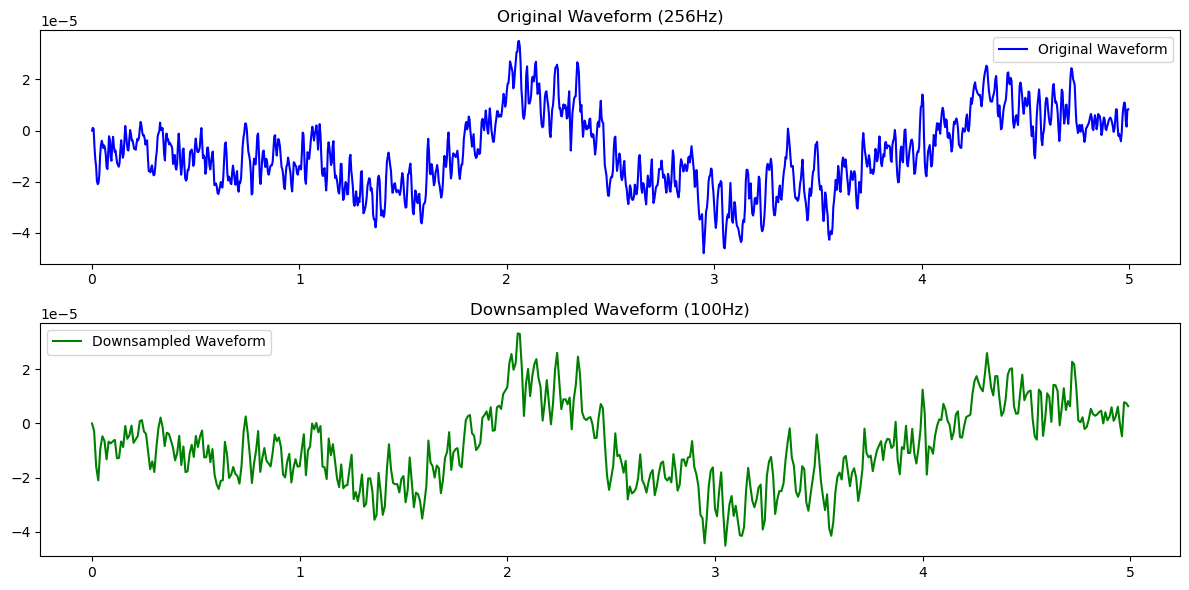

In [177]:
# Draw the original waveform and downsampled waveform
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t[:(256*5)],eeg_filtered[:(256*5)], 'b-', label='Original Waveform')
plt.legend(loc='best')
plt.title('Original Waveform (256Hz)')
plt.subplot(2, 1, 2)
plt.plot(t_downsampled[:(100*5)], eeg_downsampled[:(100*5)], 'g-', label='Downsampled Waveform')
plt.legend(loc='best')
plt.title('Downsampled Waveform (100Hz)')
plt.tight_layout()
plt.show()   